In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from scipy.optimize import differential_evolution
import timm

# ------------------------
# 1. Define Class Names
# ------------------------
CLASSES = [
    "No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation",
    "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"
]

# ------------------------
# 2. Load and Preprocess Dataset Metadata
# ------------------------
# Load CSV file containing image paths and labels
df = pd.read_csv("/student/csc490_project/shared/labels.csv")
df["label_list"] = df["Finding Labels"].apply(lambda x: x.split("|"))

# Binarize multi-label annotations
mlb = MultiLabelBinarizer(classes=CLASSES)
labels_array = mlb.fit_transform(df["label_list"])
df["labels"] = list(labels_array)

# ------------------------
# 3. Patient-Level Split
# ------------------------
unique_patients = df["Patient ID"].unique()
np.random.seed(42)
np.random.shuffle(unique_patients)

train_end = int(0.7 * len(unique_patients))
val_end = int(0.8 * len(unique_patients))

train_patients = unique_patients[:train_end]
val_patients = unique_patients[train_end:val_end]
test_patients = unique_patients[val_end:]

# Select test set only
test_df = df[df["Patient ID"].isin(test_patients)].reset_index(drop=True)

# ------------------------
# 4. Custom PyTorch Dataset Class
# ------------------------
class ChestXrayDataset(Dataset):
    """
    Dataset class for loading Chest X-ray images and labels.

    Args:
        df (pd.DataFrame): DataFrame with image metadata and labels.
        root_dir (str): Path to image directory.
        transform (callable, optional): Transformations to apply to images.
    """
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]["Image Index"])
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        labels = torch.tensor(self.df.iloc[idx]["labels"], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, labels

# ------------------------
# 5. Define Transformations and Dataloader
# ------------------------
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize for ImageNet models
])

img_dir = "/student/csc490_project/shared/preprocessed_images/preprocessed_images"
test_dataset = ChestXrayDataset(test_df, img_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# ------------------------
# 6. Load Pretrained Models
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model dictionary with model architectures and 15 output classes
models = {
    'maxvit': timm.create_model('maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k', pretrained=False, num_classes=15),
    'densenet': timm.create_model('densenet121', pretrained=False, num_classes=15),
    'coatnet': timm.create_model('coatnet_2_rw_224.sw_in12k_ft_in1k', pretrained=False, num_classes=15),
    'swin': timm.create_model('swin_large_patch4_window7_224', pretrained=False, num_classes=15),
    'convnext': timm.create_model('convnext_large.fb_in22k', pretrained=False, num_classes=15),
    'vgg19': timm.create_model('vgg19.tv_in1k', pretrained=False, num_classes=15)
}

# Load trained weights for each model
models['maxvit'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k_model.pth'))
models['densenet'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_densenet121_model.pth'))
models['coatnet'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_coatnet_2_rw_224.sw_in12k_ft_in1k_model.pth'))
models['swin'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_swin_large_patch4_window7_224_model.pth'))
models['convnext'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_convnext_large.fb_in22k_model.pth'))
models['vgg19'].load_state_dict(torch.load('/student/csc490_project/shared/training/vgg19.tv_in1k.pt'))

# Move all models to device and set to evaluation mode
for model in models.values():
    model.to(device)
    model.eval()

# ------------------------
# 7. Collect Test Predictions
# ------------------------
def collect_predictions(loader):
    """
    Generate predictions from all models on a given dataset loader.

    Args:
        loader (DataLoader): PyTorch DataLoader for dataset.

    Returns:
        dict: Dictionary of predictions from each model.
        np.ndarray: Ground truth labels.
    """
    all_preds = {name: [] for name in models}  # Initialize predictions dict
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            for name, model in models.items():
                outputs = model(images)
                probs = torch.sigmoid(outputs).cpu().numpy()
                all_preds[name].append(probs)

            all_labels.append(labels.cpu().numpy())

    # Concatenate predictions and labels across all batches
    all_preds = {k: np.concatenate(v) for k, v in all_preds.items()}
    all_labels = np.concatenate(all_labels)

    return all_preds, all_labels

# Run prediction collection
test_preds, test_labels = collect_predictions(test_loader)

/student/hasajedr/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


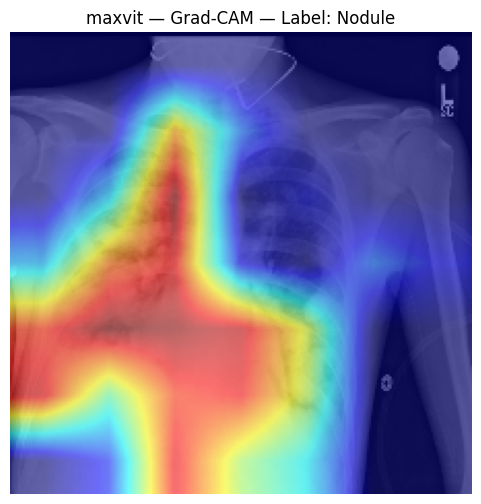

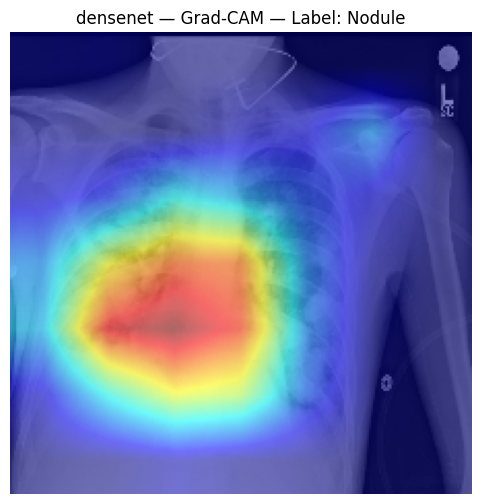

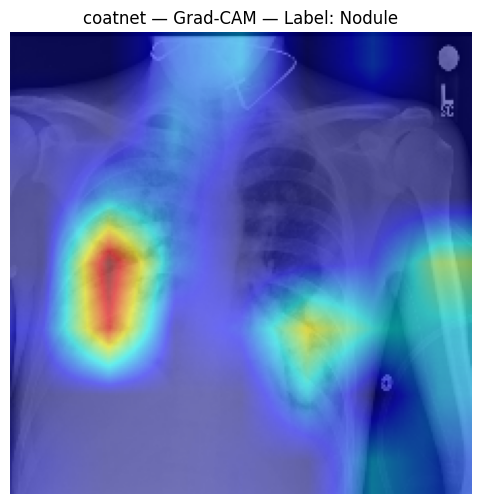

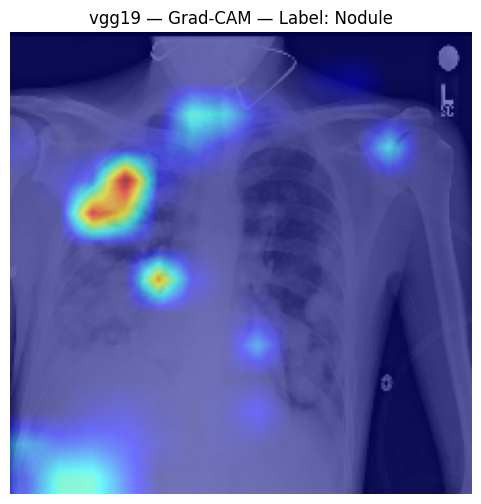

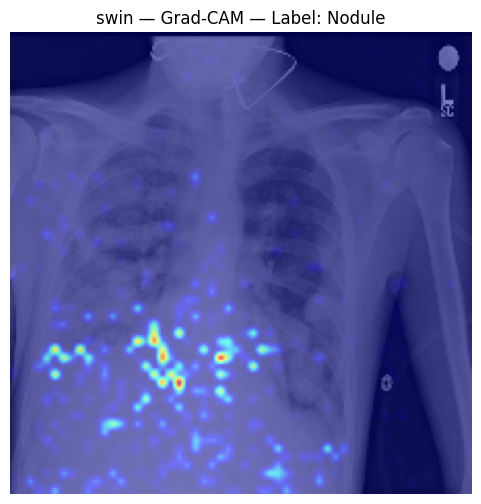

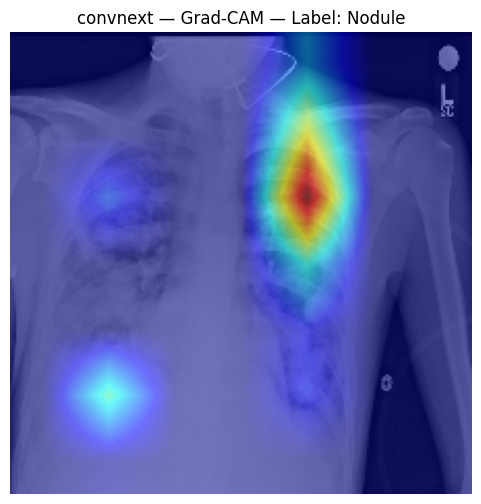

Sample 1/1 — Test Index: 3810 — True Label: Nodule
Ensemble Prediction (binary): [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
Predicted Class Labels: ['Nodule']
Top-1 Predicted Label (raw):
Nodule: 0.2584
Per-sample F1 Score: 1.0000


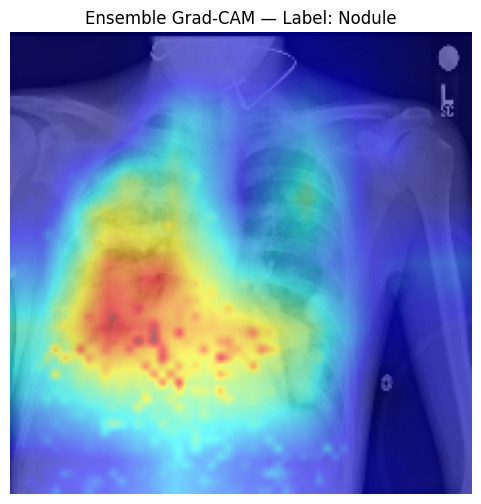

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import f1_score
import os

# Model combo and weights
best_models = ['maxvit', 'densenet', 'coatnet', 'vgg19', 'swin', 'convnext']
best_weights = [0.1663, 0.2052, 0.1524, 0.1138, 0.1747, 0.1877]

# ChestX-ray14 class names
class_names = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
               'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
               'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def normalize_cam(cam):
    """
    Normalize CAM values to [0, 1] range.
    
    Args:
        cam (np.ndarray): Raw CAM values.

    Returns:
        np.ndarray: Normalized CAM.
    """
    return (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

def get_target_layer(model, model_name):
    """
    Get appropriate target layer for Grad-CAM depending on model architecture.

    Args:
        model (nn.Module): PyTorch model.
        model_name (str): Model identifier.

    Returns:
        nn.Module: Target layer for CAM computation.
    """
    if model_name == 'maxvit':
        return model.stages[-1].blocks[-1]
    elif model_name == 'densenet':
        return model.get_submodule("features.denseblock4.denselayer16.conv2")
    elif model_name == 'coatnet':
        return list(model.stages[-1].children())[-1]
    elif model_name == 'vgg19':
        return model.get_submodule("features.35")
    elif model_name == 'swin':
        return model.patch_embed.proj
    elif model_name == 'convnext':
        return list(model.stages[3].blocks.children())[-1].conv_dw
    else:
        raise ValueError(f"Target layer not defined for {model_name}")

def get_predicted_labels(outputs, threshold=0.1):
    """
    Binarize model outputs based on threshold.

    Args:
        outputs (Tensor): Model logits.
        threshold (float): Threshold for binarization.

    Returns:
        np.ndarray: Binarized prediction matrix.
    """
    probs = torch.sigmoid(outputs)
    return (probs > threshold).int().cpu().numpy()

def multilabel_binarize(label_str, class_list):
    """
    Convert multi-label string to binary vector.

    Args:
        label_str (str): Label string, separated by '|'.
        class_list (list): All class names.

    Returns:
        np.ndarray: Binary label vector.
    """
    label_vector = np.zeros(len(class_list), dtype=int)
    for label in label_str.split('|'):
        if label in class_list:
            label_vector[class_list.index(label)] = 1
    return label_vector

# Output directory for visualizations
os.makedirs("gradcam_outputs", exist_ok=True)

# Example test image indices to analyze
sample_indices = [3810]

for idx, sample_idx in enumerate(sample_indices):
    sample_row = test_df.iloc[sample_idx]
    img_path = os.path.join(img_dir, sample_row["Image Index"])
    true_label = sample_row["Finding Labels"]

    # Load and preprocess image
    original_image = Image.open(img_path).convert("RGB")
    resized_image = original_image.resize((224, 224))
    image_np = np.array(resized_image).astype(np.float32) / 255.0
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    individual_cams = {}
    model_outputs = []

    # Process each model for CAM and prediction
    for i, model_name in enumerate(best_models):
        weight = best_weights[i]
        model = models[model_name]
        model.eval()

        # Select Grad-CAM variant based on model
        target_layer = get_target_layer(model, model_name)
        cam_method = LayerCAM if model_name == "swin" else GradCAM
        cam = cam_method(model=model, target_layers=[target_layer])

        # Generate CAM
        grayscale_cam = cam(input_tensor=input_tensor)[0]
        grayscale_cam = cv2.resize(grayscale_cam, (224, 224))
        normalized_cam = normalize_cam(grayscale_cam)
        cam_image = show_cam_on_image(image_np, normalized_cam, use_rgb=True)

        # Weight and accumulate CAM
        individual_cams[model_name] = normalized_cam * weight

        # Get weighted output
        with torch.no_grad():
            output = model(input_tensor)
            model_outputs.append(weight * output)

        # Save individual CAM
        plt.figure(figsize=(6, 6))
        plt.imshow(cam_image)
        plt.title(f"{model_name} — Grad-CAM — Label: {true_label}")
        plt.axis("off")
        save_path = f"cam_outputs/sample_{sample_idx}_{idx}_{model_name}_cam.png"
        plt.savefig(save_path)
        plt.show()

    # Ensemble CAM computation
    ensemble_cam = sum(individual_cams.values()) / sum(best_weights)
    ensemble_cam = normalize_cam(ensemble_cam)
    ensemble_cam_image = show_cam_on_image(image_np, ensemble_cam, use_rgb=True)

    # Ensemble output and prediction
    ensemble_output = sum(model_outputs) / sum(best_weights)
    predicted_labels = get_predicted_labels(ensemble_output, threshold=0.3)

    # Fallback to "No Finding" if nothing predicted
    if np.sum(predicted_labels) == 0:
        predicted_labels[0][-1] = 1

    # Get true label in binary format
    true_vector = multilabel_binarize(true_label, class_names)

    # Compute macro F1 score
    f1 = f1_score(true_vector, predicted_labels[0], average='macro')

    # Visualize and report results if F1 > 0
    if f1 > 0:
        print(f"Sample {idx + 1}/{len(sample_indices)} — Test Index: {sample_idx} — True Label: {true_label}")
        print(f"Ensemble Prediction (binary): {predicted_labels}")
        predicted_indices = np.where(predicted_labels[0] == 1)[0]
        predicted_classes = [class_names[i] for i in predicted_indices]
        print(f"Predicted Class Labels: {predicted_classes}")

        top1_idx = torch.argmax(ensemble_output[0]).item()
        top1_class = class_names[top1_idx]
        top1_score = float(ensemble_output[0][top1_idx])
        print("Top-1 Predicted Label (raw):")
        print(f"{top1_class}: {top1_score:.4f}")

        print(f"Per-sample F1 Score: {f1:.4f}")

        # Save ensemble CAM image
        plt.figure(figsize=(6, 6))
        plt.imshow(ensemble_cam_image)
        plt.title(f"Ensemble Grad-CAM — Label: {true_label}")
        plt.axis("off")
        plt.savefig(f"cam_outputs/sample_{sample_idx}_{idx}_ensemble.png")
        plt.show()
    else:
        print(f"Sample {sample_idx}: F1 = {f1:.4f} — skipping (incorrect prediction)")


In [4]:
import numpy as np

top_k = 5
probs = torch.sigmoid(ensemble_output[0]).cpu().numpy()
topk_indices = np.argsort(probs)[::-1][:top_k]

print(f"\n🔝 Top-{top_k} Predicted Probabilities:")
for i in topk_indices:
    print(f"{class_names[i]}: {probs[i]:.4f}")



🔝 Top-5 Predicted Probabilities:
Nodule: 0.5643
Infiltration: 0.2720
Pneumonia: 0.2603
Atelectasis: 0.1570
Mass: 0.1119


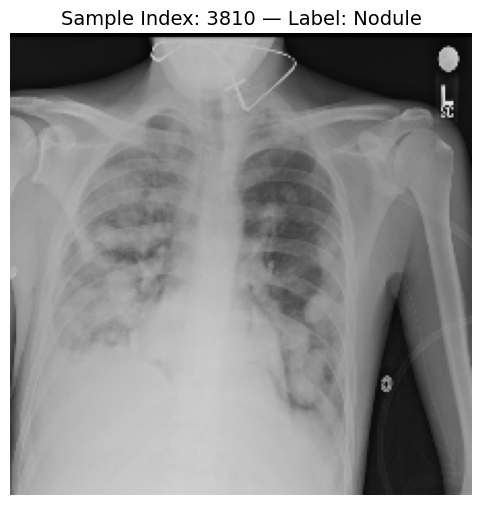

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

sample_idx = 3810
sample_row = test_df.iloc[sample_idx]
img_path = os.path.join(img_dir, sample_row["Image Index"])
true_label = sample_row["Finding Labels"]

original_image = Image.open(img_path).convert("RGB")
resized_image = original_image.resize((224, 224))

plt.figure(figsize=(6, 6))
plt.imshow(resized_image)
plt.title(f"Sample Index: {sample_idx} — Label: {true_label}", fontsize=14)
plt.axis("off")
plt.show()
